# **Imports**

In [1]:
# Import all the good stuff
from typing import Optional

import numpy as np
import torch
import matplotlib.pyplot as plt

# **Mount**

In [2]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Mounted at /content/gdrive


In [3]:
import os
from pathlib import Path

folder = "Colab Notebooks"
project_dir = "NeRF"

base_path = Path("/content/gdrive/My Drive/")
project_path = base_path / folder / project_dir
os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 디렉토리 위치: {os.getcwd()}")

현재 디렉토리 위치: /content/gdrive/My Drive/Colab Notebooks/NeRF


# **Download Dataset**

In [5]:
# Download sample data used in the official tiny_nerf example
import os
if not os.path.exists('tiny_nerf_data.npz'):
    !wget https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# **Load Input Images and Poses**

torch.Size([100, 100, 100, 3])
torch.Size([100, 4, 4])
tensor(138.8889, device='cuda:0', dtype=torch.float64)


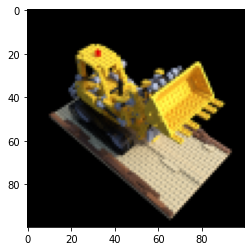

In [7]:
# Load input images, poses, and intrinsics
data = np.load("tiny_nerf_data.npz")

# Images
images = data["images"]
testimg = torch.from_numpy(images[101]).to(device) # 102번째 사진으로 test
images = torch.from_numpy(images[:100, ..., :3]).to(device) # 100개의 사진 선정, 100*100, RGB
print(images.shape) # 100개의 사진, 100*100, RGB

# Camera extrinsics (poses)
tform_cam2world = data["poses"]
testpose = torch.from_numpy(tform_cam2world[101]).to(device) # 102번째 사진으로 test
tform_cam2world = torch.from_numpy(tform_cam2world[:100, ...]).to(device)
print(tform_cam2world.shape) # 100개의 사진, ??

# Focal length (intrinsics)
focal_length = data["focal"]
focal_length = torch.from_numpy(focal_length).to(device)
print(focal_length) #하나의 고유값??

# Height and width of each image
height, width = images.shape[1:3] # 100*100

# Near and far clipping thresholds for depth values.
# 왜 2와 6이지??
near_thresh = 2.
far_thresh = 6.

plt.imshow(testimg.detach().cpu().numpy())
plt.show()

In [8]:
def get_minibatches(inputs: torch.Tensor, chunksize: Optional[int] = 1024 * 8):
  r"""Takes a huge tensor (ray "bundle") and splits it into a list of minibatches.
  Each element of the list (except possibly the last) has dimension `0` of length
  `chunksize`.
  """
  return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]

# **Optimize NeRF**

#### Bridging PyTorch and TensorFlow functionality

In [9]:
def meshgrid_xy(tensor1: torch.Tensor, tensor2: torch.Tensor) -> (torch.Tensor, torch.Tensor):
    """Mimick np.meshgrid(..., indexing="xy") in pytorch. torch.meshgrid only allows "ij" indexing.
    (If you're unsure what this means, safely skip trying to understand this, and run a tiny example!)

    Args:
      tensor1 (torch.Tensor): Tensor whose elements define the first dimension of the returned meshgrid.
      tensor2 (torch.Tensor): Tensor whose elements define the second dimension of the returned meshgrid.
    """
    # TESTED
    ii, jj = torch.meshgrid(tensor1, tensor2)
    return ii.transpose(-1, -2), jj.transpose(-1, -2)


def cumprod_exclusive(tensor: torch.Tensor) -> torch.Tensor:
  r"""Mimick functionality of tf.math.cumprod(..., exclusive=True), as it isn't available in PyTorch.

  Args:
    tensor (torch.Tensor): Tensor whose cumprod (cumulative product, see `torch.cumprod`) along dim=-1
      is to be computed.
  
  Returns:
    cumprod (torch.Tensor): cumprod of Tensor along dim=-1, mimiciking the functionality of
      tf.math.cumprod(..., exclusive=True) (see `tf.math.cumprod` for details).
  """
  # TESTED
  # Only works for the last dimension (dim=-1)
  dim = -1
  # Compute regular cumprod first (this is equivalent to `tf.math.cumprod(..., exclusive=False)`).
  cumprod = torch.cumprod(tensor, dim)
  # "Roll" the elements along dimension 'dim' by 1 element.
  cumprod = torch.roll(cumprod, 1, dim)
  # Replace the first element by "1" as this is what tf.cumprod(..., exclusive=True) does.
  cumprod[..., 0] = 1.
  
  return cumprod

#### Compute the "bundle" of rays through all pixels of an image.

In [10]:
# 특정 각도에서, 각 픽셀에 대한 광선 구하기(r(t) = o + td)
# 함수 내용은 모르겠습니다.. 각 픽셀마다의 r(t) 계산 위한 o, d를 output으로 함
# output shape: 100*100(픽셀) * 2(o, d) * 3(xyz)

def get_ray_bundle(height: int, width: int, focal_length: float, tform_cam2world: torch.Tensor):

  ii, jj = meshgrid_xy(
      torch.arange(width).to(tform_cam2world),
      torch.arange(height).to(tform_cam2world)
  )
  directions = torch.stack([(ii - width * .5) / focal_length,
                            -(jj - height * .5) / focal_length,
                            -torch.ones_like(ii)
                           ], dim=-1)
  ray_directions = torch.sum(directions[..., None, :] * tform_cam2world[:3, :3], dim=-1)
  ray_origins = tform_cam2world[:3, -1].expand(ray_directions.shape)
  return ray_origins, ray_directions

#### Compute "query" 3D points given the "bundle" of rays.

In [11]:
def compute_query_points_from_rays(
    ray_origins: torch.Tensor,
    ray_directions: torch.Tensor,
    near_thresh: float,
    far_thresh: float,
    num_samples: int,
    randomize: Optional[bool] = True
) -> (torch.Tensor, torch.Tensor):

  depth_values = torch.linspace(near_thresh, far_thresh, num_samples).to(ray_origins)
  
  if randomize is True: # noise
    noise_shape = list(ray_origins.shape[:-1]) + [num_samples]
    depth_values = depth_values + torch.rand(noise_shape).to(ray_origins) * (far_thresh - near_thresh) / num_samples

  # 각 t(depth_values)에 대한 r(t) 구하기 => uniform sampling
  query_points = ray_origins[..., None, :] + ray_directions[..., None, :] * depth_values[..., :, None]
  return query_points, depth_values

#### Volumetric rendering

In [12]:
def render_volume_density(
    radiance_field: torch.Tensor,
    ray_origins: torch.Tensor,
    depth_values: torch.Tensor
) -> (torch.Tensor, torch.Tensor, torch.Tensor):

  # RGB(색상)와 a(밀도) 분리
  sigma_a = torch.nn.functional.relu(radiance_field[..., 3])
  rgb = torch.sigmoid(radiance_field[..., :3])
  
  # 볼륨 렌더링
  one_e_10 = torch.tensor([1e10], dtype=ray_origins.dtype, device=ray_origins.device)
  dists = torch.cat((depth_values[..., 1:] - depth_values[..., :-1],
                  one_e_10.expand(depth_values[..., :1].shape)), dim=-1)
  alpha = 1. - torch.exp(-sigma_a * dists)
  weights = alpha * cumprod_exclusive(1. - alpha + 1e-10)

  rgb_map = (weights[..., None] * rgb).sum(dim=-2)
  depth_map = (weights * depth_values).sum(dim=-1)
  acc_map = weights.sum(-1)

  return rgb_map, depth_map, acc_map

#### Positional encoding

In [13]:
# positional encoding
# tensor와 torch.Tensor의 차이점??
# shape: (data, 3) => (data, 3 * (2 * num_encoding_functions + 1))

def positional_encoding(
    tensor, num_encoding_functions=6, include_input=True, log_sampling=True
) -> torch.Tensor:

  encoding = [tensor] if include_input else []

  # 값의 범위 설정
  frequency_bands = None # 지수 연산 or 선형 연산
  if log_sampling: # 지수 연산(균등하게 n개를 샘플링한 이후 2**x, default)
      frequency_bands = 2.0 ** torch.linspace(
            0.0, # start
            num_encoding_functions - 1, # end
            num_encoding_functions, # steps
            dtype=tensor.dtype,
            device=tensor.device,
        )
  else: # 선형 연산(1부터 2**x까지를 범위로 하여 균등하게 n개를 샘플링)
      frequency_bands = torch.linspace(
          2.0 ** 0.0, # start
          2.0 ** (num_encoding_functions - 1), # end
          num_encoding_functions, # steps
          dtype=tensor.dtype,
          device=tensor.device,
      )

  # sin, cos 연산
  for freq in frequency_bands:
      for func in [torch.sin, torch.cos]:
          encoding.append(func(tensor * freq))

  if len(encoding) == 1:
      return encoding[0]
  else:
      return torch.cat(encoding, dim=-1)

#### NeRF: Network architecture

In [14]:
# 모델 정의(논문에서의 설명보다는 간소화된 상태)
# MLP로 구성, xyz -> RGBa 변환
# 굉장히 대충 구성되어 있네요..? depth만 더 길게 해도 성능 괜찮을 것 같은데
# 그래서 8중으로 해봤는데 그래도 성능이 별로더라고요..

class VeryTinyNeRF(torch.nn.Module):
  def __init__(self, filter_size=128, num_encoding_functions=6):
    super(VeryTinyNeRF, self).__init__()

    # Input layer (default: 39 -> 128)
    self.layer1 = torch.nn.Linear(3 + 3 * 2 * num_encoding_functions, filter_size)
    # Layer 2 (default: 128 -> 128)
    self.layer2 = torch.nn.Linear(filter_size, filter_size)
    # Layer 3 (default: 128 -> 4)
    self.layer3 = torch.nn.Linear(filter_size, 4)
    # Short hand for torch.nn.functional.relu
    self.relu = torch.nn.functional.relu
  
  def forward(self, x):
    x = self.relu(self.layer1(x))
    x = self.relu(self.layer2(x))
    x = self.layer3(x)
    return x

In [15]:
# 모델 정의(논문에서의 설명보다는 간소화된 상태)
# MLP로 구성, xyz -> RGBa 변환
# 그래서 depth를 늘려봤습니다

class VeryTinyNeRF2(torch.nn.Module):
  def __init__(self, filter_size=128, num_encoding_functions=6):
    super(VeryTinyNeRF2, self).__init__()

    # Input layer (default: 39 -> 128)
    self.layer1 = torch.nn.Linear(3 + 3 * 2 * num_encoding_functions, filter_size)
    # Layer 2 (default: 128 -> 128)
    self.layer2 = torch.nn.Linear(filter_size, filter_size)
    # Layer 3 (default: 128 -> 4)
    self.layer3 = torch.nn.Linear(filter_size, 4)
    # Short hand for torch.nn.functional.relu
    self.relu = torch.nn.functional.relu
  
  def forward(self, x):
    x = self.relu(self.layer1(x))
    for i in range(8):
      x = self.relu(self.layer2(x))
    x = self.layer3(x)
    return x

#### Train TinyNeRF

In [16]:
# One iteration of TinyNeRF (forward pass).
def render(height, width, focal_length, tform_cam2world,
                             near_thresh, far_thresh, depth_samples_per_ray,
                             encoding_function, get_minibatches_function):
  
  # 선택한 각도에서, 각 픽셀에 대한 광선 구하기(r(t) = o + td)
  ray_origins, ray_directions = get_ray_bundle(height, width, focal_length,
                                               tform_cam2world)
  
  # 각 광선에 대한 정보를 가지고 샘플링
  query_points, depth_values = compute_query_points_from_rays(
      ray_origins, ray_directions, near_thresh, far_thresh, depth_samples_per_ray
  )
  flattened_query_points = query_points.reshape((-1, 3))

  # positional encoding 적용
  encoded_points = encoding_function(flattened_query_points)

  # model 적용(xyz * (2 * L_embed + 1) -> RGBa)
  # batch 단위로 적용
  batches = get_minibatches_function(encoded_points, chunksize=chunksize)
  predictions = []
  for batch in batches:
    predictions.append(model(batch))
  radiance_field_flattened = torch.cat(predictions, dim=0)

  unflattened_shape = list(query_points.shape[:-1]) + [4]
  radiance_field = torch.reshape(radiance_field_flattened, unflattened_shape)

  # 볼륨 렌더링
  rgb_predicted, _, _ = render_volume_density(radiance_field, ray_origins, depth_values)

  return rgb_predicted

In [25]:
num_encoding_functions = 6
encode = lambda x: positional_encoding(x, num_encoding_functions=num_encoding_functions)
depth_samples_per_ray = 64

# Chunksize (Note: this isn't batchsize in the conventional sense. This only
# specifies the number of rays to be queried in one go. Backprop still happens
# only after all rays from the current "bundle" are queried and rendered).
chunksize = 16384  # Use chunksize of about 4096 to fit in ~1.4 GB of GPU memory.

lr = 1e-3
num_iters = 2000
display_every = 100

model = VeryTinyNeRF(num_encoding_functions=num_encoding_functions).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

psnrs = []
iternums = []


Loss: 0.1555263102054596


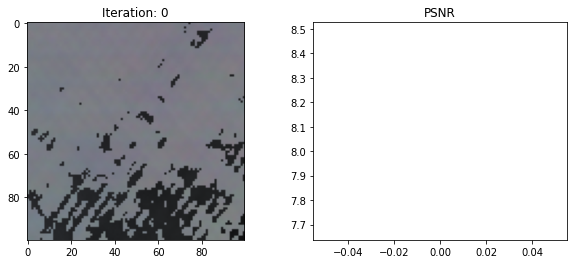

Loss: 0.0639839768409729


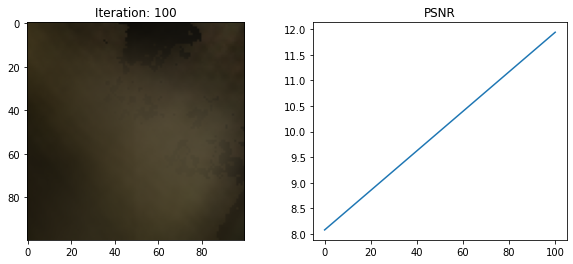

Loss: 0.06317304819822311


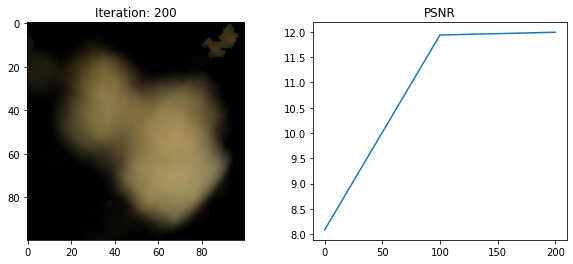

Loss: 0.07940676808357239


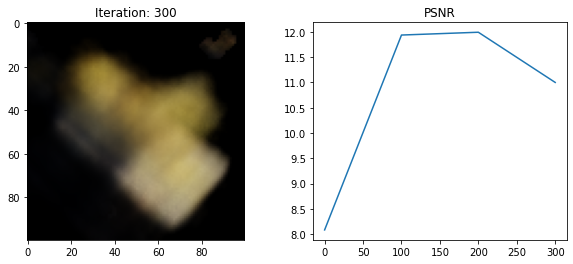

Loss: 0.06363099068403244


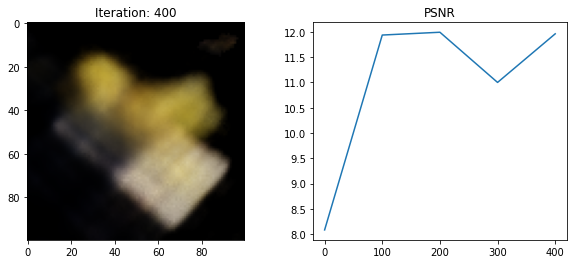

Loss: 0.04137802869081497


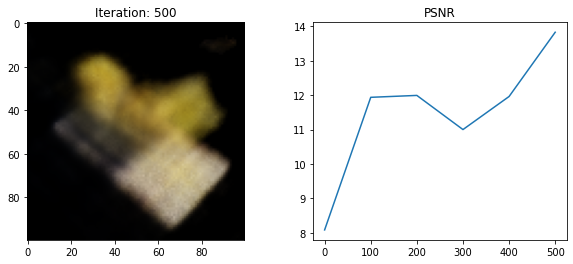

Loss: 0.08792591094970703


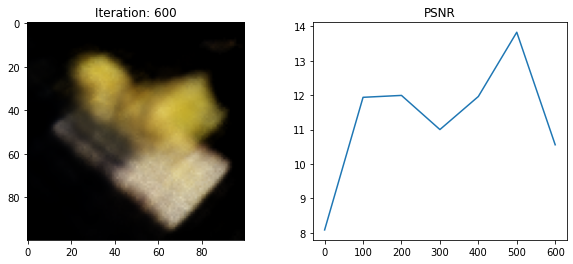

Loss: 0.07664911448955536


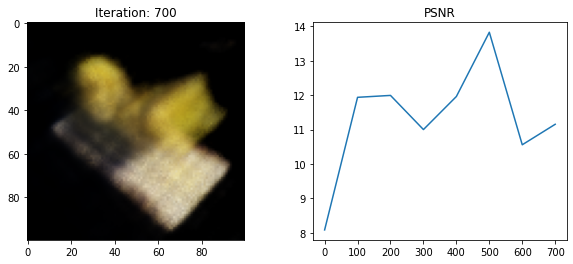

Loss: 0.08609136193990707


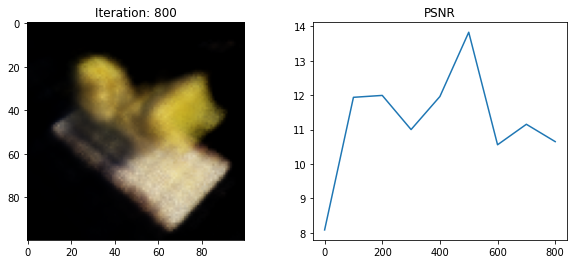

Loss: 0.06134363263845444


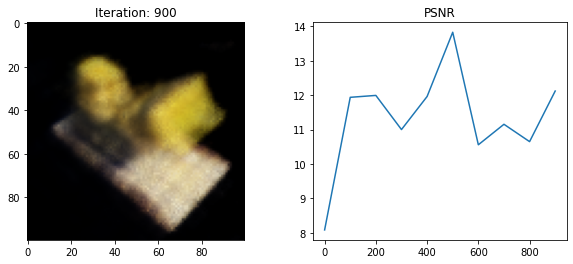

Loss: 0.03406623750925064


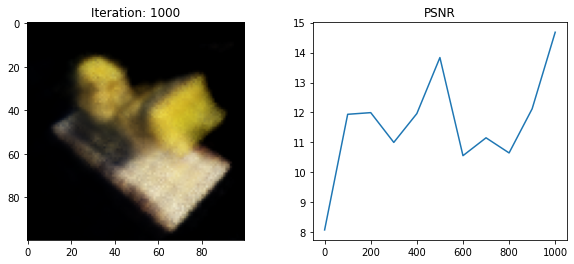

Loss: 0.0585574135184288


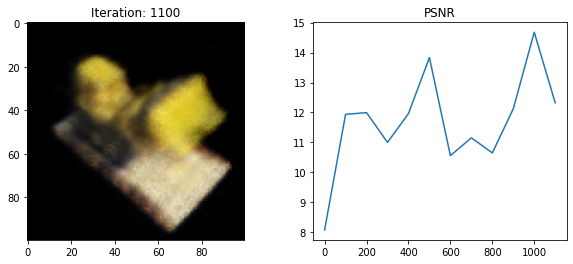

Loss: 0.09010573476552963


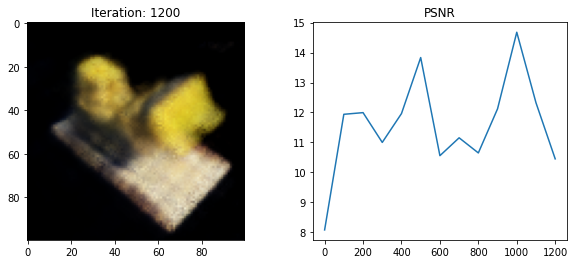

Loss: 0.0803171694278717


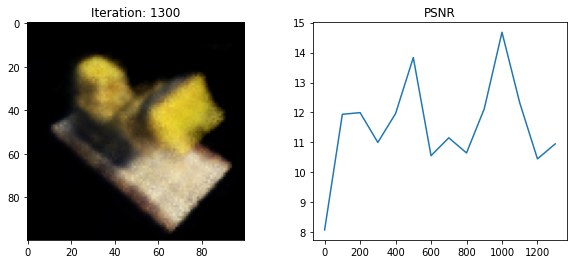

Loss: 0.08195026218891144


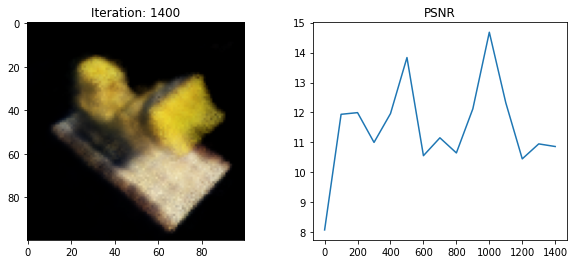

Loss: 0.10324882715940475


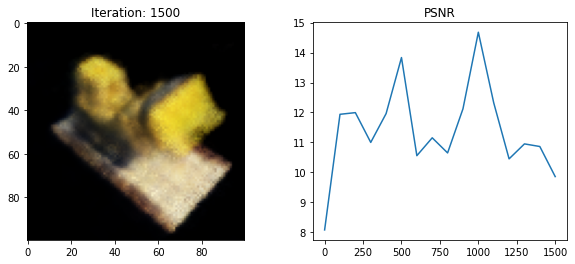

Loss: 0.08936871588230133


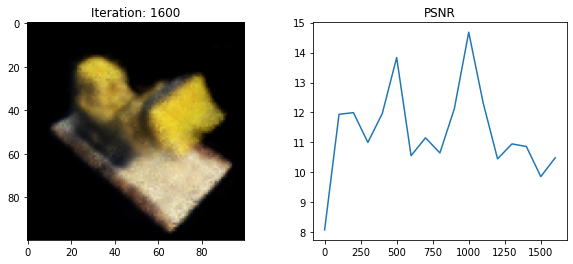

Loss: 0.10115976631641388


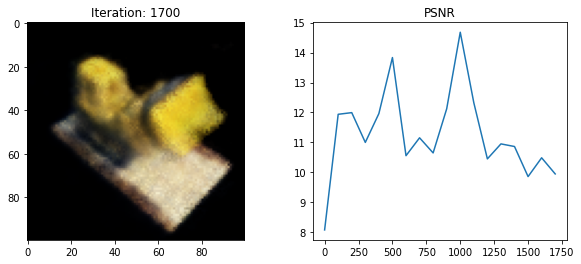

Loss: 0.07897710800170898


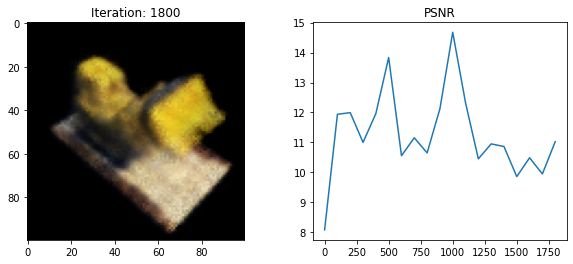

Loss: 0.14892835915088654


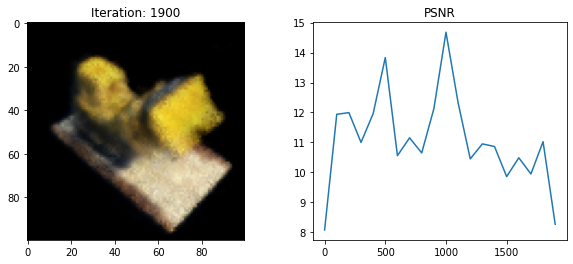

Loss: 0.14704565703868866


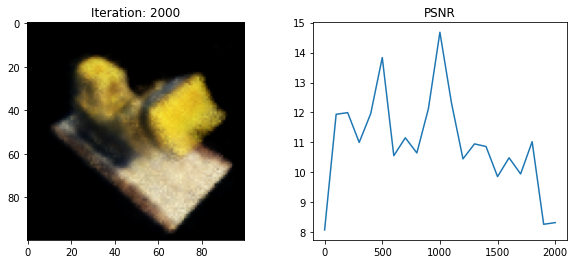

Done!


In [26]:
for i in range(num_iters+1):

  # 랜덤으로 하나의 학습에 사용할 이미지 가져오기
  img_rand = np.random.randint(images.shape[0])
  target_img = images[img_rand].to(device)
  target_tform_cam2world = tform_cam2world[img_rand].to(device)

  # 학습
  rgb_predicted = render(height, width, focal_length,
                                           target_tform_cam2world, near_thresh,
                                           far_thresh, depth_samples_per_ray,
                                           encode, get_minibatches)
  loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # 학습 횟수가 100의 배수면 logging
  if i % display_every == 0:

    # 현재까지의 학습 결과를 가지고 렌더링
    rgb_predicted = render(height, width, focal_length,
                                             testpose, near_thresh,
                                             far_thresh, depth_samples_per_ray,
                                             encode, get_minibatches)
    loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
    print("Loss:", loss.item())

    #그래프 출력
    plt.figure(figsize=(10,4)) #가로 10인치, 세로 4인치

    #그래프 출력 - 현재까지 학습 결과로 렌더링한 이미지
    plt.subplot(121) #rows = 1, cols = 2의 index = 1
    plt.imshow(rgb_predicted.detach().cpu().numpy())
    plt.title(f'Iteration: {i}')
  
    #그래프 출력 - epoch당 PSNR(평가 지표, 높을수록 좋음)
    plt.subplot(122) #rows = 1, cols = 2의 index = 2
    psnr = -10. * torch.log10(loss)
    psnrs.append(psnr.item())
    iternums.append(i)
    plt.plot(iternums, psnrs)
    plt.title('PSNR')

    plt.show()

print('Done!')